# 🌸 Floranet

---
- 902011, Moleri Andrea, a.moleri@campus.unimib.it
- 865939, Armani Filippo, f.armani1@campus.unimib.it
---

## 🎯 Domain and Objectives

The notebook you are about to read contains a project called Floranet, which aims to classify, through the use of machine learning and deep learning techniques, a dataset containing 102 classes of different flowers. In particular, the dataset used is known as the [Oxford Flower Dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html), compiled by Maria-Elena Nilsback and Andrew Zisserman. Each of the 102 classes consists of a variable number ranging from 40 to 258 images per class. The images have large scale, pose and light variations. In addition, there are categories that have large variations within the category and several very similar categories. The dataset is visualized using isomap with shape and colour features. Our aim is therefore to investigate the possibilities of building models in order to solve the classification task. In other words, given an image of a flower, we want to be able to correctly identify and recognize the flower in question, minimizing the margin of error as much as possible.

## 💾 Importing the Data

In the following code cell, we download and prepare the dataset required for later analysis. The process begins by specifying a list of URLs for the required files, including images (`102flowers.tgz`), segmentation masks (`102segmentations.tgz`), and a MATLAB file containing labels (`imagelabels.mat`). First, the code checks whether a directory named `Data` exists in the parent directory. If it does not, the directory is created. For each URL in the list, the script extracts the file name from the URL, checks whether the file already exists in the target directory, and downloads it if missing. The progress is communicated to the user via messages printed in the console.

For files that require further processing (such as decompression), a helper function named `decompress` is invoked. This function uses the Python `tarfile` module to extract the compressed content into the target directory. For better organization, the function also renames the extracted directories to meaningful names like `images` and `segmented_images`. The output of the cell confirms whether each file already exists or has been newly downloaded. If decompression is needed, the appropriate subdirectories are created to store the prepared data. Please note that the `segmented_images` archive has been imported for completeness’s sake with respect to the original dataset, but will not be used in the project at hand. However, it remains available if, in the future, changes in the scope of the notebook or alternative tasks to be carried out were to require it.

In [3]:
import os
import pathlib
import tarfile
import requests
import shutil

def decompress(url, out_dir, old_name, new_name):
    """
    Decompresses a tar.gz file and moves a specific folder to a new location.

    Parameters:
    url (str): The URL of the file to be decompressed.
    out_dir (str): The output directory where the file is decompressed.
    old_name (str): The name of the folder inside the decompressed archive.
    new_name (str): The new name and location for the folder after decompression.

    Returns:
    None
    """
    file_name = url.split('/')[-1]
    file_path = os.path.join(out_dir, file_name)

    print(f"Extracting {file_name}...", end=" ")

    # Open the tar.gz file and extract its contents to the output directory
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path=out_dir)

    # Rename (or move) the extracted folder
    shutil.move(old_name, new_name)

    print(f"Completed!")

# URLs of the resources to be downloaded
url = ["https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz",
       "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102segmentations.tgz",
       "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"]

# Define the output directory
out_dir = os.path.join(pathlib.Path('./').parent.absolute(), "Data")
os.makedirs(out_dir, exist_ok=True)  # Create the directory if it does not exist

# Iterate through each URL and download the file if it does not already exist
for u in url:
    file_name = u.split('/')[-1]  # Extract the file name from the URL
    file_path = os.path.join(out_dir, file_name)  # Full path for the downloaded file

    if not os.path.exists(file_path):
        print(f"Downloading {file_name}...", end=" ")
        response = requests.get(u)  # Perform the HTTP GET request
        with open(file_path, 'wb') as f:
            f.write(response.content)  # Save the content to a file
        print(f"Completed!")
    else:
        print(f"The file {file_name} already exists.")  # Skip download if the file exists

# Define directories for decompressed content
images_dir = os.path.join(out_dir, "images")
segmented_dir = os.path.join(out_dir, "segmented_images")
labels_path = os.path.join(out_dir, 'imagelabels.mat')

# Decompress and organize the flower images
if not os.path.exists(images_dir):
    decompress(url[0], out_dir, os.path.join(out_dir, "jpg"), images_dir)

# Decompress and organize the segmented images
if not os.path.exists(segmented_dir):
    decompress(url[1], out_dir, os.path.join(out_dir, "segmim"), segmented_dir)

The file 102flowers.tgz already exists.
The file 102segmentations.tgz already exists.
The file imagelabels.mat already exists.


##  🏷️ Mapping Images to Labels

The following code cell is designed to map the image files of the dataset to their respective flower names using the labels provided in the `imagelabels.mat` file. The MATLAB file containing the labels is loaded using the `scipy.io.loadmat` function. The flower class labels are stored in the `labels` variable, and since MATLAB indices start at 1, these are adjusted for Python's 0-based indexing. Additionally, a list of flower names is used to map class indices to human-readable flower names. For reference, the Oxford University website (the same one we got the dataset from) lists the 102 categories that make up the dataset, [each with an associated image.](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html) This web page was helpful in verifying that the label mapping in the following code cell was formally correct. This mapping is facilitated by the `ID_NAMES` dictionary, where each index is paired with its corresponding flower name.

In a nutshell, the script identifies all image files in the `images_dir` directory, ensuring only `.jpg` files are considered. These file names are sorted to align with the order of the labels in the dataset. A list comprehension is used to retrieve the flower names corresponding to the labels for each image. Finally, the `image_name` and `flower_name` pairs are stored in a dictionary and converted into a Pandas DataFrame for easier manipulation and analysis. This DataFrame (`df`) serves as a structured representation of the dataset, where each row links an image file to its associated flower name. Although the step of associating "human-readable" labels to images is not useful for machine learning purposes, it is still useful to apply it in order to better comment on the data analysis phase conducted in the code cell that is located after the one you are reading right now.

In [4]:
import os
from scipy.io import loadmat
import pandas as pd

# Load the labels from the .mat file
labels_data = loadmat(labels_path)  # Load MATLAB data as a dictionary
labels = labels_data['labels'][0]  # Extract the labels array from the dictionary

# Define the flower names corresponding to the label IDs
NAMES = [
    "Pink Primrose", "Hard-Leaved Pocket Orchid", "Canterbury Bells",
    "Sweet Pea", "English Marigold", "Tiger Lily", "Moon Orchid",
    "Bird Of Paradise", "Monkshood", "Globe Thistle", "Snapdragon",
    "Colt's Foot", "King Protea", "Spear Thistle", "Yellow Iris",
    "Globe-Flower", "Purple Coneflower", "Peruvian Lily", "Balloon Flower",
    "Giant White Arum Lily", "Fire Lily", "Pincushion Flower", "Fritillary",
    "Red Ginger", "Grape Hyacinth", "Corn Poppy", "Prince Of Wales Feathers",
    "Stemless Gentian", "Artichoke", "Sweet William", "Carnation",
    "Garden Phlox", "Love In The Mist", "Mexican Aster", "Alpine Sea Holly",
    "Ruby-Lipped Cattleya", "Cape Flower", "Great Masterwort", "Siam Tulip",
    "Lenten Rose", "Barbeton Daisy", "Daffodil", "Sword Lily", "Poinsettia",
    "Bolero Deep Blue", "Wallflower", "Marigold", "Buttercup", "Oxeye Daisy",
    "Common Dandelion", "Petunia", "Wild Pansy", "Primula", "Sunflower",
    "Pelargonium", "Bishop Of Llandaff", "Gaura", "Geranium", "Orange Dahlia",
    "Pink-Yellow Dahlia?", "Cautleya Spicata", "Japanese Anemone",
    "Black-Eyed Susan", "Silverbush", "Californian Poppy", "Osteospermum",
    "Spring Crocus", "Bearded Iris", "Windflower", "Tree Poppy", "Gazania",
    "Azalea", "Water Lily", "Rose", "Thorn Apple", "Morning Glory",
    "Passion Flower", "Lotus", "Toad Lily", "Anthurium", "Frangipani",
    "Clematis", "Hibiscus", "Columbine", "Desert-Rose", "Tree Mallow",
    "Magnolia", "Cyclamen", "Watercress", "Canna Lily", "Hippeastrum",
    "Bee Balm", "Ball Moss", "Foxglove", "Bougainvillea", "Camellia", "Mallow",
    "Mexican Petunia", "Bromelia", "Blanket Flower", "Trumpet Creeper",
    "Blackberry Lily"
]

# Map label IDs (0-indexed) to flower names
ID_NAMES = dict(zip([x for x in range(len(NAMES))], NAMES))

# Retrieve the sorted list of image file names
image_files = sorted([img for img in os.listdir(images_dir) if img.endswith('.jpg')])

# Map the labels to their corresponding flower names, ensuring correct indexing
flower_names = [ID_NAMES[label - 1] for label in labels[:len(image_files)]]

# Create a dictionary for the DataFrame
data = {'image_name': image_files, 'flower_name': flower_names}

# Create a pandas DataFrame to organize the image and flower data
df = pd.DataFrame(data)

## 🔎 Data Analysis

The following code cell performs an analysis of the training data, offering valuable insights into its composition, structure, and dynamics. The analysis involves both quantitative summaries and qualitative visualizations. The dataset comprises a total of `8,189` images, distributed across `102` flower classes. The class distribution is uneven, with the most populated class containing `258` images (Petunia) and the least populated class containing `40` images (e.g., Pink Primrose). This may highlight the need for potential class-balancing strategies during model training. In this regard, a bar plot illustrates the distribution of images per class, offering a clear visual interpretation of the imbalances across categories. Classes such as Petunia and Passion Flower dominate the dataset, while several classes have fewer samples, which might pose challenges when training CNN models.

To provide a qualitative understanding, sample images from the top 5 most populated classes are displayed. Each row in the grid corresponds to a class, showcasing five randomly chosen images belonging to the class in question. This visualization provides insights into intra-class variability and image quality. Regarding this visualization, we start to recognize interesting phenomena. First, the Petunia class presents a clear example of pose variation. In other words, objects within the same category can be presented in several different poses and angles. Furthermore, the Wallflower and the Watercress classes present an example of inter-class similarity. This means that objects in the two classes could easily be confused with each other. Finally, we notice that the Water Lily class presents intra-class variation. Simply put, objects within the same category can have striking differences in appearance. Furthermore, a comparison is made between flowers extracted from 10 randomly selected classes, and flowers extracted from a specific class. This visualization was made to underscore the diversity within the dataset, and to highlight the consistency of samples for a particular category at the same time.

After these visualizations, the dimensions (width and height) of all images were analyzed to compute statistics such as mean, standard deviation, and range. The dataset exhibits varying resolutions, with an average image size of approximately `630×534` pixels. The aspect ratio distribution was plotted, showing a concentration around `1.2` with some outliers. These findings indicate relatively uniform image dimensions, simplifying preprocessing requirements. While these aspect ratio variations shouldn't cause any problems, it's still a good idea to keep them in mind, as the images will need to be rescaled to be properly fed into the convolutional neural networks we'll build. Finally, the average number of images per class is `80.28`, but the significant variance value highlights potential issues of class imbalance. Strategies such as data augmentation may be necessary to mitigate the impact during training.

Total number of images: 8189

Number of images per class (ordered by count):
Class | Petunia: 258 images
Class | Passion Flower: 251 images
Class | Wallflower: 196 images
Class | Water Lily: 194 images
Class | Watercress: 184 images
Class | Rose: 171 images
Class | Frangipani: 166 images
Class | Foxglove: 162 images
Class | Cyclamen: 154 images
Class | Lotus: 137 images
Class | Hibiscus: 131 images
Class | Sword Lily: 130 images
Class | Bougainvillea: 128 images
Class | Barbeton Daisy: 127 images
Class | Thorn Apple: 120 images
Class | Geranium: 114 images
Class | Clematis: 112 images
Class | Bishop Of Llandaff: 109 images
Class | Pink-Yellow Dahlia?: 109 images
Class | Cape Flower: 108 images
Class | Morning Glory: 107 images
Class | Anthurium: 105 images
Class | Californian Poppy: 102 images
Class | Azalea: 96 images
Class | Primula: 93 images
Class | Poinsettia: 93 images
Class | Common Dandelion: 92 images
Class | Fritillary: 91 images
Class | Camellia: 91 images
Class | Snapdragon

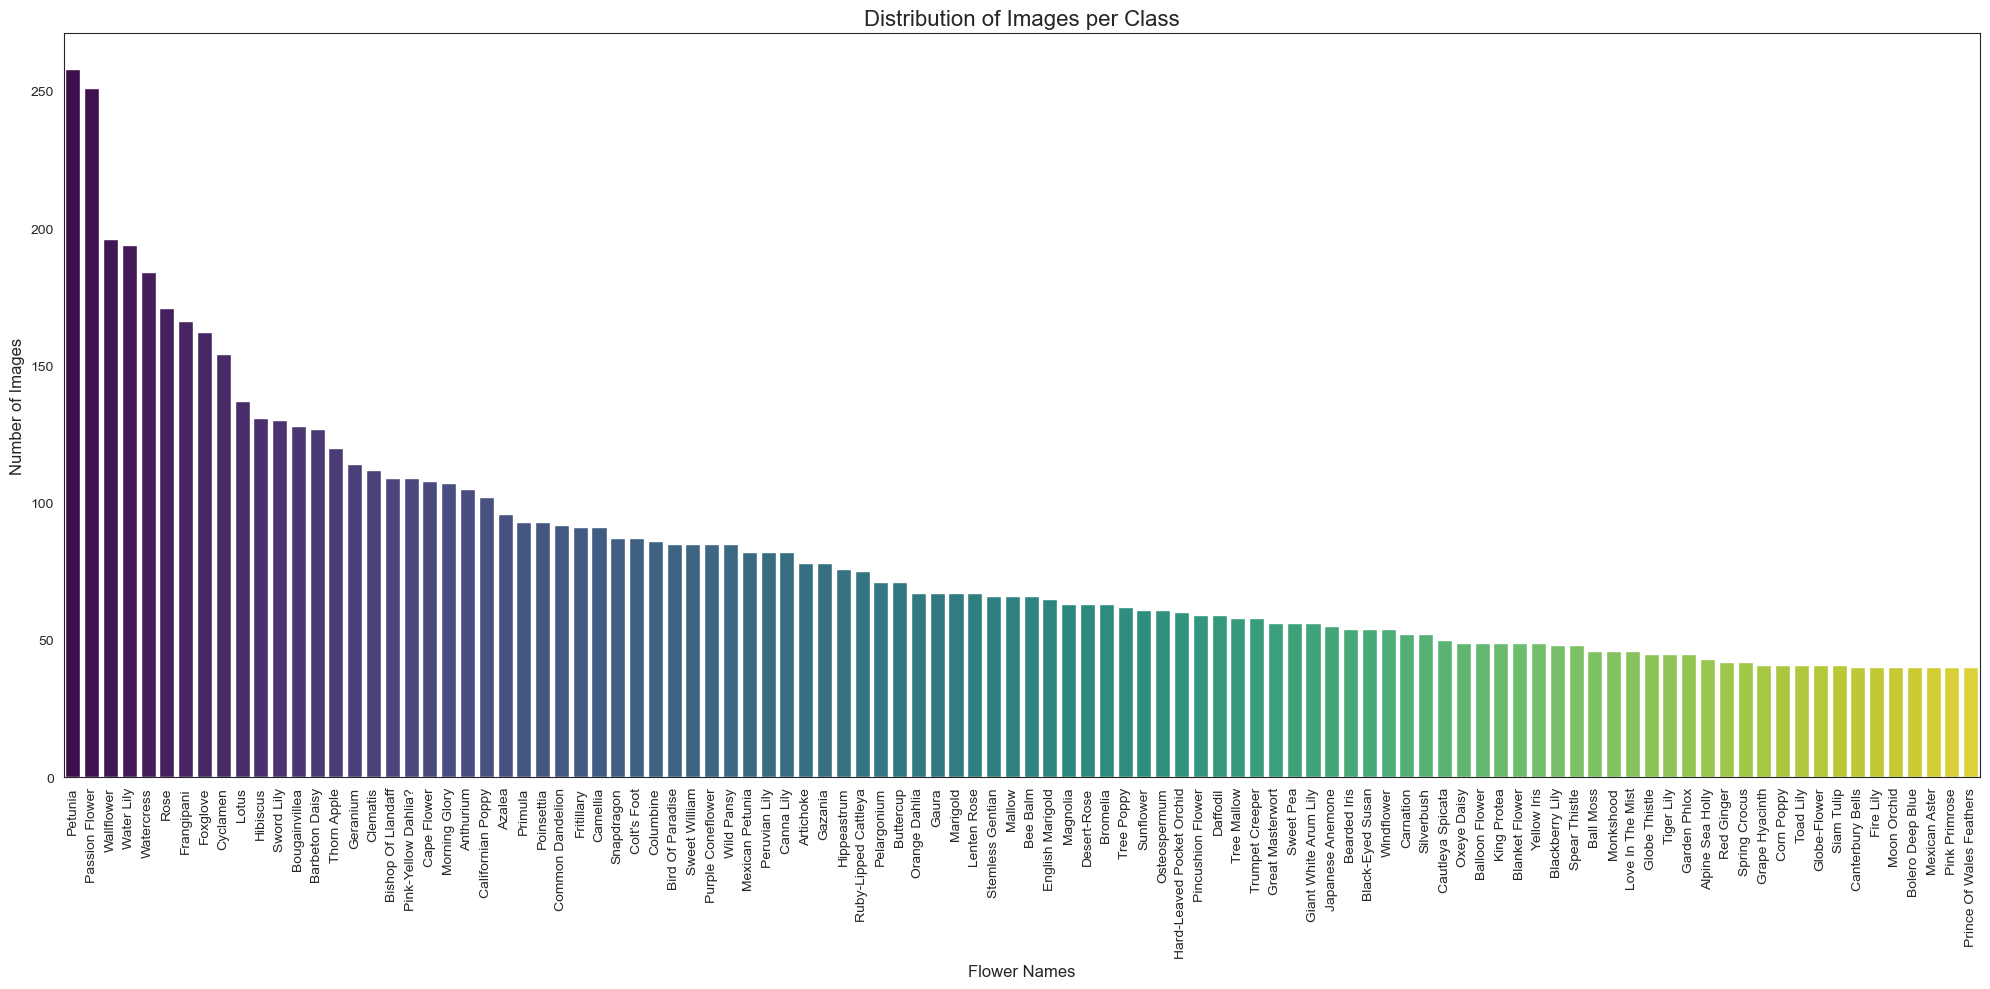

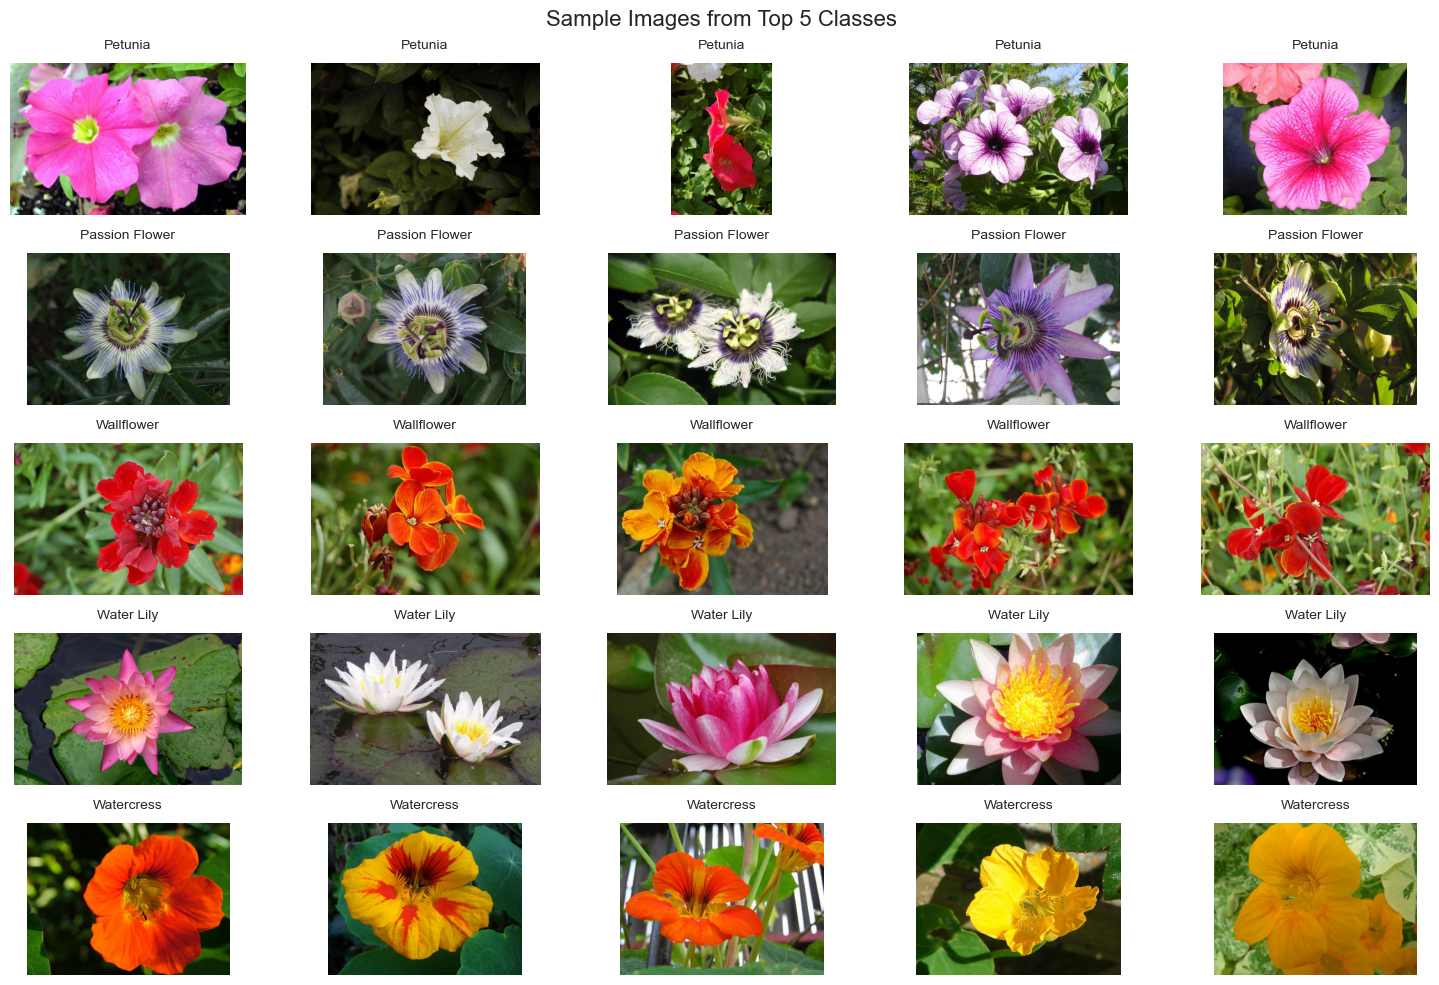

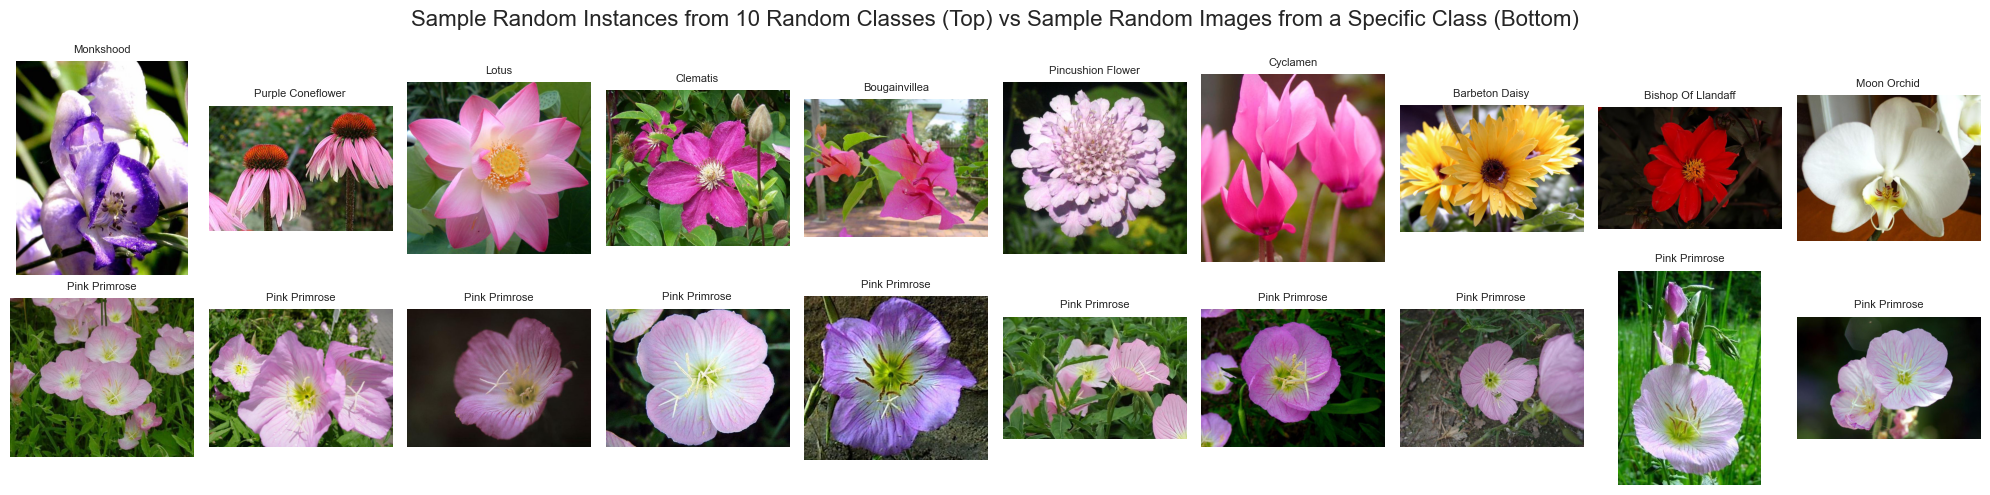

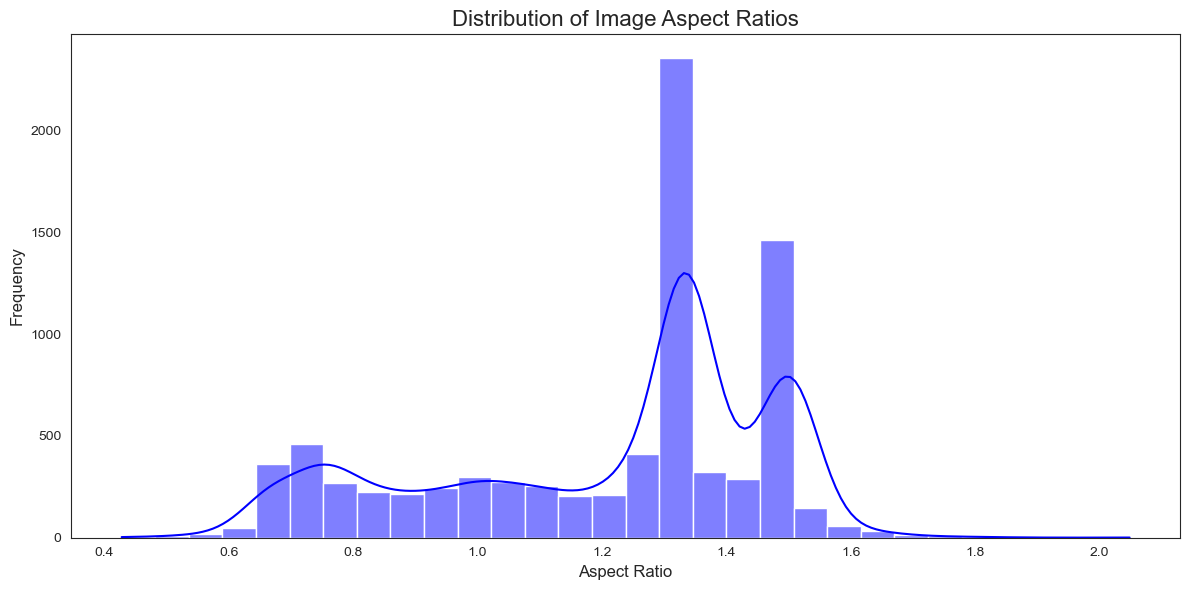


Image Dimension Statistics:
             Width       Height  Aspect Ratio
count  8189.000000  8189.000000   8189.000000
mean    630.160581   534.352058      1.210391
std      95.988254    75.453540      0.270855
min     500.000000   500.000000      0.428082
25%     501.000000   500.000000      1.000000
50%     667.000000   500.000000      1.332000
75%     699.000000   501.000000      1.398000
max    1024.000000  1168.000000      2.048000

Average number of images per class: 80.28


In [6]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# Print the total number of images in the dataset
num_images = len(df)
print(f"Total number of images: {num_images}")

# Count the number of images per class
images_per_class = df['flower_name'].value_counts()
print("\nNumber of images per class (ordered by count):")
for flower_name, count in images_per_class.items():
    print(f"Class | {flower_name}: {count} images")

# Plot the distribution of images per class
plt.figure(figsize=(20, 10))
sns.set_style("white")
sns.barplot(x=images_per_class.index, y=images_per_class.values, palette="viridis")
plt.xlabel('Flower Names', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Distribution of Images per Class', fontsize=16)
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

# Display sample images from the top 5 classes by image count
top_classes = images_per_class.head(5).index

fig, axes = plt.subplots(len(top_classes), 5, figsize=(15, 10))
for i, flower_name in enumerate(top_classes):
    # Randomly sample 5 images for the current flower class
    sample_images = df[df['flower_name'] == flower_name].sample(5)['image_name'].values
    for j, image_name in enumerate(sample_images):
        img_path = os.path.join(images_dir, image_name)
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')  # Hide axis for better visualization
        axes[i, j].set_title(f"{flower_name}", fontsize=10, pad=10)
plt.suptitle('Sample Images from Top 5 Classes', fontsize=16)
plt.tight_layout()
plt.show()

# Randomly sample 10 flower classes and 10 images from a specific class
random_classes = df['flower_name'].drop_duplicates().sample(10).values
class_1_images = df[df['flower_name'] == NAMES[0]].sample(10)['image_name'].values

# Plot images from random classes (top row) and specific class (bottom row)
fig, axes = plt.subplots(2, 10, figsize=(20, 5))
for i, flower_name in enumerate(random_classes):
    # Randomly sample one image for each random class
    image_name = df[df['flower_name'] == flower_name].sample(1)['image_name'].values[0]
    img_path = os.path.join(images_dir, image_name)
    img = Image.open(img_path)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"{flower_name}", fontsize=8)

for i, image_name in enumerate(class_1_images):
    # Display 10 random images for the specific flower class
    img_path = os.path.join(images_dir, image_name)
    img = Image.open(img_path)
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title("Pink Primrose", fontsize=8)

plt.suptitle('Sample Random Instances from 10 Random Classes (Top) vs Sample Random Images from a Specific Class (Bottom)', fontsize=16)
plt.tight_layout()
plt.show()

# Analyze image dimensions (width and height)
image_sizes = []
for image_name in df['image_name']:
    img_path = os.path.join(images_dir, image_name)
    with Image.open(img_path) as img:
        image_sizes.append(img.size)  # Append image dimensions as (width, height)

# Create a DataFrame for image sizes and calculate aspect ratio
sizes_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])
sizes_df['Aspect Ratio'] = sizes_df['Width'] / sizes_df['Height']

# Plot the distribution of image aspect ratios
plt.figure(figsize=(12, 6))
sns.histplot(sizes_df['Aspect Ratio'], kde=True, color='blue', bins=30)
plt.xlabel('Aspect Ratio', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Image Aspect Ratios', fontsize=16)
plt.tight_layout()
plt.show()

# Print summary statistics for image dimensions
print("\nImage Dimension Statistics:")
print(sizes_df.describe())

# Calculate and print the average number of images per class
avg_images_per_class = images_per_class.mean()
print(f"\nAverage number of images per class: {avg_images_per_class:.2f}")

## 🗂️ Creating Training, Validation and Test Sets

In the following code cell, the dataset has been split into three sets: a training set, a validation set, and a test set, with the training set containing `70%` of the data (5732 images), the validation set `15%` of the data (1228 images), and the test set `15%` of the data (1229 images). This `70/15/15` split ensures that the data is distributed in a way that is suitable for both training and evaluation. After the split, an analysis of the resulting sets is conducted. In the training set, the class distribution is relatively balanced, though there are some classes with fewer images, such as class `0`, `2`, and `6`, which each contains around `28` to `32` images. On the other hand, some classes like class `50` are overrepresented with `181` images. Despite these variations, the splitting ensures that the dataset maintains a proportional representation of each class in the training set.

The validation set follows a similar distribution, though there are slight differences in the number of images per class, with some smaller classes like `0`, `2`, and `6` having fewer images than larger ones. Even so, the validation set still mirrors the overall class distribution well, ensuring that it is representative and will help in assessing the model's generalization ability. Larger classes, such as class `50`, again have a higher number of samples, which is expected due to the overall distribution in the full dataset. The test set shows a comparable trend, maintaining a balanced class distribution similar to the validation set. Once again, classes with a larger number of images, like class `50`, are slightly more represented, but the overall distribution remains stable across the test set. Overall, the stratified splitting method should be effective in ensuring that each set—training, validation, and test—contains a similar proportion of each class. This is important for training a model that can generalize well, as it reduces the risk of the model being biased toward any one class.

In addition to the data splitting process, One-Hot Encoding was applied to the target labels in the dataset. This technique is important for handling categorical data, especially in multi-class classification problems. One-Hot Encoding transforms each class label into a binary vector, where the vector length corresponds to the number of unique classes in the dataset. For each sample, the vector has a `"1"` in the position that corresponds to the class label and `"0"s` in all other positions. For instance, if there are `102` unique classes, the target label for a sample from class `50` will be represented as a vector of length `102`, where the `50th` position is marked as `"1"` and all other positions are `"0"`. This encoding ensures that the model can interpret the target labels correctly during the training process, as it treats each class as an independent category rather than a numerical value. One-Hot Encoding also prevents the model from assuming any ordinal relationship between the classes, which is essential when the classes themselves are categorical and do not have a natural ordering. This transformation is applied consistently across the training, validation, and test sets, ensuring that the model's predictions are evaluated using the same format. The preprocessed data has been saved into separate CSV files for further use, making it, therefore, ready for the training and model evaluation phases.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Map flower names to corresponding label indices
df['label'] = df['flower_name'].map({name: idx for idx, name in enumerate(NAMES)})

# Define random seed for reproducibility
seed = 42

# Split the dataset into training, validation, and test sets
# 30% of the data will be used for the temporary set (validation + test)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=seed)

# Split the temporary set (30%) into validation and test sets (50% each)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=seed)

# Initialize OneHotEncoder to convert labels into one-hot encoded vectors
encoder = OneHotEncoder(sparse_output=False)

# Perform one-hot encoding on the 'label' column for training, validation, and test sets
train_labels_encoded = encoder.fit_transform(train_df[['label']])
valid_labels_encoded = encoder.transform(valid_df[['label']])
test_labels_encoded = encoder.transform(test_df[['label']])

# Generate column names for the one-hot encoded classes (class_0, class_1, ..., class_n)
class_columns = [f"class_{int(c)}" for c in encoder.categories_[0]]

# Add the one-hot encoded columns to the corresponding DataFrames
train_df = pd.concat([train_df.reset_index(drop=True), pd.DataFrame(train_labels_encoded, columns=class_columns)], axis=1)
valid_df = pd.concat([valid_df.reset_index(drop=True), pd.DataFrame(valid_labels_encoded, columns=class_columns)], axis=1)
test_df = pd.concat([test_df.reset_index(drop=True), pd.DataFrame(test_labels_encoded, columns=class_columns)], axis=1)

# Calculate the number of images in each set
train_size = len(train_df)
valid_size = len(valid_df)
test_size = len(test_df)

# Calculate the total size of the original dataset
total_size = len(df)

# Calculate the class distribution in each set
train_class_dist = train_df['label'].value_counts().sort_index()
valid_class_dist = valid_df['label'].value_counts().sort_index()
test_class_dist = test_df['label'].value_counts().sort_index()

# Calculate the percentage distribution for each dataset
train_percentage = (train_size / total_size) * 100
valid_percentage = (valid_size / total_size) * 100
test_percentage = (test_size / total_size) * 100

# Print out a summary of the data split
print("Data Split Summary\n" + "="*30)
print(f"Total number of images: {total_size} images\n")
print(f"Training Set: {train_size} images ({train_percentage:.2f}%)")
print(f"Validation Set: {valid_size} images ({valid_percentage:.2f}%)")
print(f"Test Set: {test_size} images ({test_percentage:.2f}%)\n")

# Print class distribution for each dataset
print("Class Distribution:")
print("-"*30)

# Function to display class distribution in a given dataset
def display_class_distribution(class_dist, set_name):
    print(f"\nClass distribution in the {set_name}:")
    print(f"{'Class':<10} {'Number of Images':<20} {'Percentage':<15}")
    print("-" * 50)
    for label, count in class_dist.items():
        # Calculate the percentage of each class in the total dataset
        percentage = (count / total_size) * 100
        print(f"{label:<10} {count:<20} {percentage:<15.2f}%")
    print("\n")

# Display class distribution for the training, validation, and test sets
display_class_distribution(train_class_dist, "Training Set")
display_class_distribution(valid_class_dist, "Validation Set")
display_class_distribution(test_class_dist, "Test Set")

# Save the processed data to CSV files for future use
train_df.to_csv('Data/train_set.csv', index=False)
valid_df.to_csv('Data/valid_set.csv', index=False)
test_df.to_csv('Data/test_set.csv', index=False)

# Print summary information about the dataset
print("="*30)
print(f"Total number of classes: {df['label'].nunique()}")
print(f"Classes range from 0 to {df['label'].max()}")

Data Split Summary
Total number of images: 8189 images

Training Set: 5732 images (70.00%)
Validation Set: 1228 images (15.00%)
Test Set: 1229 images (15.01%)

Class Distribution:
------------------------------

Class distribution in the Training Set:
Class      Number of Images     Percentage     
--------------------------------------------------
0          28                   0.34           %
1          42                   0.51           %
2          28                   0.34           %
3          39                   0.48           %
4          46                   0.56           %
5          32                   0.39           %
6          28                   0.34           %
7          59                   0.72           %
8          32                   0.39           %
9          32                   0.39           %
10         61                   0.74           %
11         61                   0.74           %
12         34                   0.42           %
13         3

# Tentativo di Rete

# Secondo Tentativo di Rete

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import VGG16, DenseNet121, InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import math
import numpy as np
import matplotlib.pyplot as plt

# Funzione per creare il modello VGG16
def create_model_vgg(input_shape=(224, 224, 3), num_classes=102, freeze_percentage=0.7, dropout_rate=0.3):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True
    total_layers = len(base_model.layers)
    layers_to_freeze = math.ceil(total_layers * freeze_percentage)
    for layer in base_model.layers[:layers_to_freeze]:
        layer.trainable = False
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(256, activation=None, kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    output = layers.Dense(num_classes, activation='softmax', dtype='float32', name='predictions')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# Funzione per creare il modello DenseNet121
def create_model_densenet(input_shape=(224, 224, 3), num_classes=102, freeze_percentage=0.7, dropout_rate=0.3):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True
    total_layers = len(base_model.layers)
    layers_to_freeze = math.ceil(total_layers * freeze_percentage)
    for layer in base_model.layers[:layers_to_freeze]:
        layer.trainable = False
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(256, activation=None, kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    output = layers.Dense(num_classes, activation='softmax', dtype='float32', name='predictions')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# Funzione per creare il modello InceptionV3
def create_model_inceptionv3(input_shape=(224, 224, 3), num_classes=102, freeze_percentage=0.7, dropout_rate=0.3):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True
    total_layers = len(base_model.layers)
    layers_to_freeze = math.ceil(total_layers * freeze_percentage)
    for layer in base_model.layers[:layers_to_freeze]:
        layer.trainable = False
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(256, activation=None, kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    output = layers.Dense(num_classes, activation='softmax', dtype='float32', name='predictions')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# Funzione per definire il learning rate scheduler
def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr + 1e-5
    return lr * tf.math.exp(-0.1)

# Funzione per allenare il modello
def train_model(model, train_df, valid_df, images_dir, class_columns, batch_size=64, epochs=25, image_size=(224, 224)):
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')
    valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=images_dir,
        x_col='image_name',
        y_col=class_columns,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='raw')
    valid_generator = valid_datagen.flow_from_dataframe(
        valid_df,
        directory=images_dir,
        x_col='image_name',
        y_col=class_columns,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='raw')
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1)
    model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
    lr_scheduler = LearningRateScheduler(lr_schedule)
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=valid_generator,
        callbacks=[early_stopping, model_checkpoint, lr_scheduler],
        verbose=1)
    return history

# Creazione del modello per VGG16
model_vgg = create_model_vgg()

# Allenamento del modello VGG16
history_vgg = train_model(model_vgg, train_df, valid_df, images_dir, class_columns)

# Creazione del modello per DenseNet121
model_densenet = create_model_densenet()

# Allenamento del modello DenseNet121
history_densenet = train_model(model_densenet, train_df, valid_df, images_dir, class_columns)

# Creazione del modello per InceptionV3
model_inception = create_model_inceptionv3()

# Allenamento del modello InceptionV3
history_inception = train_model(model_inception, train_df, valid_df, images_dir, class_columns)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

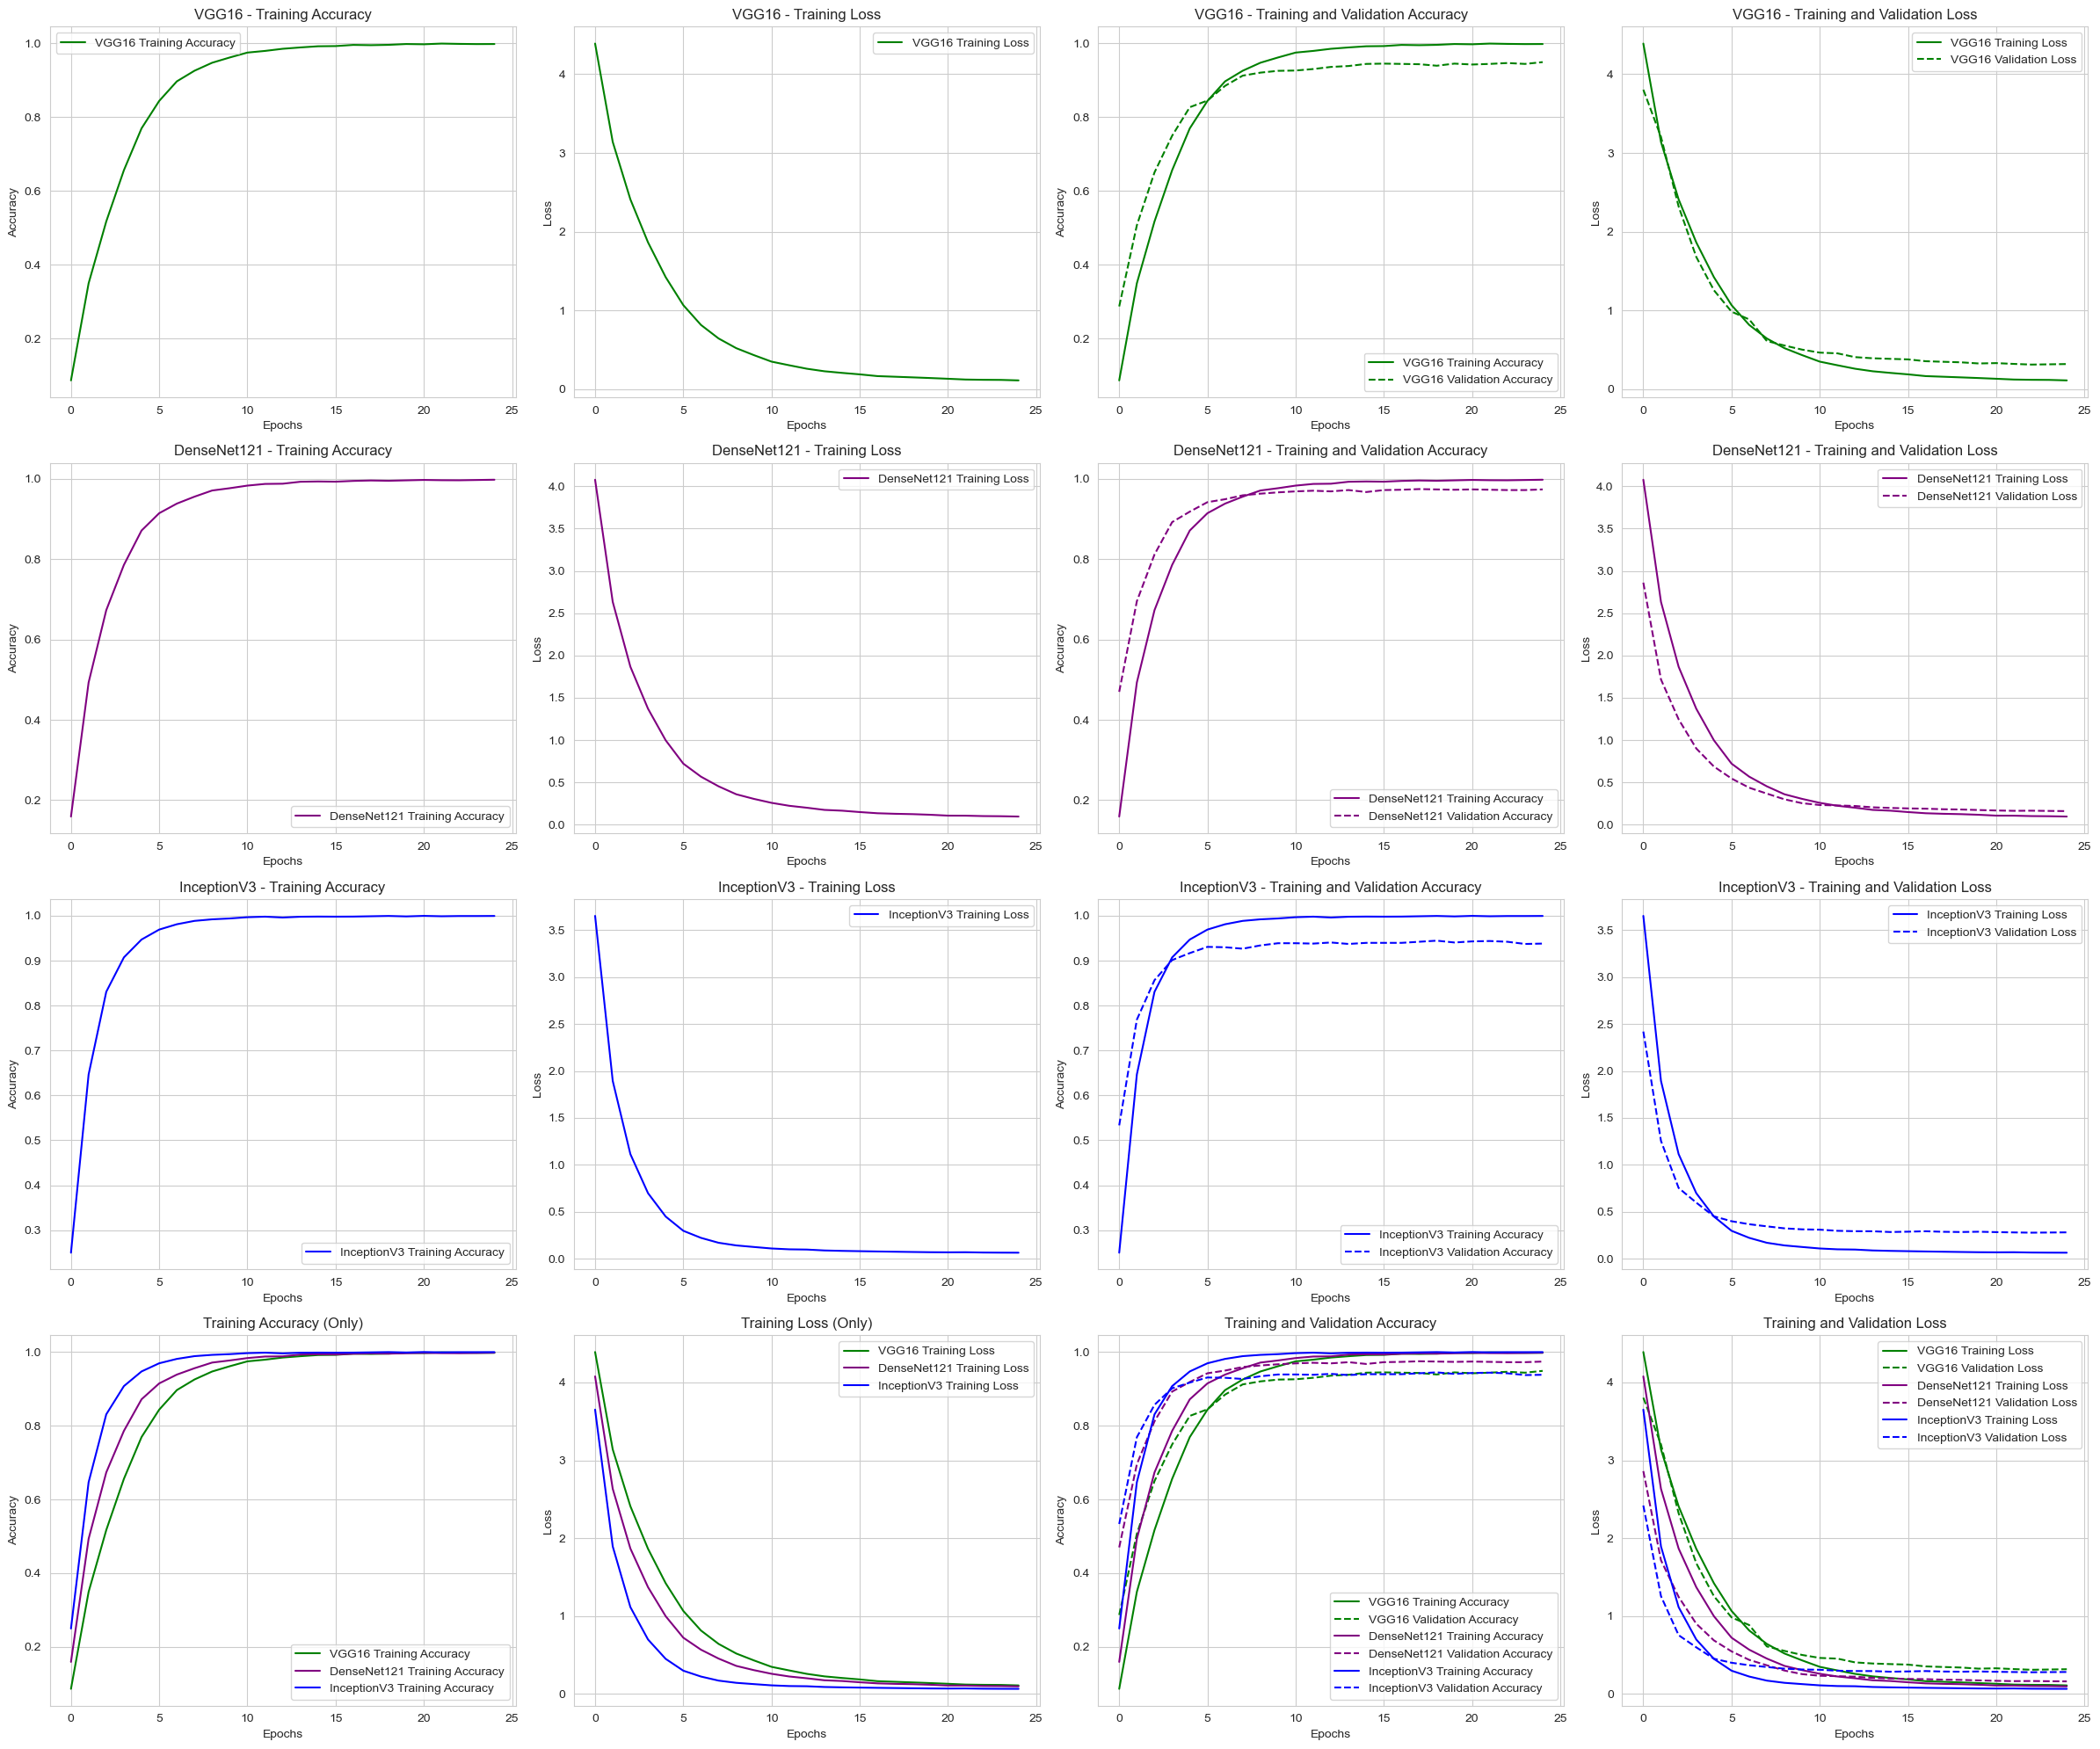

In [19]:
import matplotlib.pyplot as plt

# Funzione per tracciare tutti i grafici con aggiunta di "solo Training" a sinistra e grafico compatto alla fine
def plot_detailed_metrics_and_combined(history_vgg, history_densenet, history_inception):
    models = ['VGG16', 'DenseNet121', 'InceptionV3']
    histories = [history_vgg, history_densenet, history_inception]

    # Colori personalizzati
    colors = ['green', 'purple', 'blue']

    plt.figure(figsize=(24, 20))

    # Colori standard per ogni modello
    for i, history in enumerate(histories):
        # Plot per "Training Accuracy"
        plt.subplot(4, 4, 4 * i + 1)
        plt.plot(history.history['accuracy'], label=f'{models[i]} Training Accuracy', color=colors[i])
        plt.title(f'{models[i]} - Training Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot per "Training Loss"
        plt.subplot(4, 4, 4 * i + 2)
        plt.plot(history.history['loss'], label=f'{models[i]} Training Loss', color=colors[i])
        plt.title(f'{models[i]} - Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot per "Training e Validation Accuracy"
        plt.subplot(4, 4, 4 * i + 3)
        plt.plot(history.history['accuracy'], label=f'{models[i]} Training Accuracy', color=colors[i])
        plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{models[i]} Validation Accuracy', color=colors[i])
        plt.title(f'{models[i]} - Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot per "Training e Validation Loss"
        plt.subplot(4, 4, 4 * i + 4)
        plt.plot(history.history['loss'], label=f'{models[i]} Training Loss', color=colors[i])
        plt.plot(history.history['val_loss'], linestyle='--', label=f'{models[i]} Validation Loss', color=colors[i])
        plt.title(f'{models[i]} - Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

    # Aggiungi grafici riassuntivi per Training Accuracy e Training Loss
    plt.subplot(4, 4, 13)
    plt.plot(history_vgg.history['accuracy'], label='VGG16 Training Accuracy', color='green')
    plt.plot(history_densenet.history['accuracy'], label='DenseNet121 Training Accuracy', color='purple')
    plt.plot(history_inception.history['accuracy'], label='InceptionV3 Training Accuracy', color='blue')
    plt.title('Training Accuracy (Only)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(4, 4, 14)
    plt.plot(history_vgg.history['loss'], label='VGG16 Training Loss', color='green')
    plt.plot(history_densenet.history['loss'], label='DenseNet121 Training Loss', color='purple')
    plt.plot(history_inception.history['loss'], label='InceptionV3 Training Loss', color='blue')
    plt.title('Training Loss (Only)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Grafico compatto per Accuracy e Loss (Training + Validation) con colori distinti
    plt.subplot(4, 4, 15)
    plt.plot(history_vgg.history['accuracy'], label='VGG16 Training Accuracy', color='green')
    plt.plot(history_vgg.history['val_accuracy'], linestyle='--', label='VGG16 Validation Accuracy', color='green')
    plt.plot(history_densenet.history['accuracy'], label='DenseNet121 Training Accuracy', color='purple')
    plt.plot(history_densenet.history['val_accuracy'], linestyle='--', label='DenseNet121 Validation Accuracy', color='purple')
    plt.plot(history_inception.history['accuracy'], label='InceptionV3 Training Accuracy', color='blue')
    plt.plot(history_inception.history['val_accuracy'], linestyle='--', label='InceptionV3 Validation Accuracy', color='blue')

    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(4, 4, 16)
    plt.plot(history_vgg.history['loss'], label='VGG16 Training Loss', color='green')
    plt.plot(history_vgg.history['val_loss'], linestyle='--', label='VGG16 Validation Loss', color='green')
    plt.plot(history_densenet.history['loss'], label='DenseNet121 Training Loss', color='purple')
    plt.plot(history_densenet.history['val_loss'], linestyle='--', label='DenseNet121 Validation Loss', color='purple')
    plt.plot(history_inception.history['loss'], label='InceptionV3 Training Loss', color='blue')
    plt.plot(history_inception.history['val_loss'], linestyle='--', label='InceptionV3 Validation Loss', color='blue')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Confronto e visualizzazione dei risultati in un layout dettagliato con grafico compatto
plot_detailed_metrics_and_combined(history_vgg, history_densenet, history_inception)